# The JPEG algorithm

In [75]:
# Importing our classes
from jpeg.image import MacroBlock, MyImage
from skimage.io import imshow
import numpy as np
import matplotlib.pyplot as plt

This notebook will present to you the underlying principles of the JPEG compression algorithm. We will be detailing each steps as well as testing the effectiveness of the compression.

## Greyscale compression

An image can be represented by a linear combination of each element of its canonical basis. (Which is represented by a matrix having 1 at the given pixel and 0 elsewhere).
It is difficult to know which information to cut while still retaining good accuracy in the canonical basis.

We thus will be using the DCT, which has the advantage of decomposing the image with a basis where the lower indices correspond to lower frequencies, and the higher frequencies to high frequencies. That way we can cut from the image the frequencies deemed "less important", and compress it.

Before applying the transform, we will be splitting the image into macroblocks of size 8x8.
The advantage of 8x8 blocks is that there is less variation in frequency. Therefore, the compression algorithm will be applied on those 8x8 blocks representing the image.


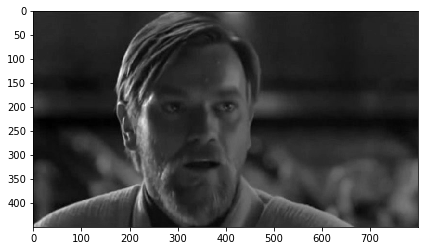

In [2]:
obi = MyImage.from_image("hello_there.jpg").grayscale()
imshow(obi.array)
qfactor = 50

To be able to split the image in 8x8 blocks, we have to add padding to the images so that its dimensions are multiples of 8.

To avoid JPEG artifacts, and avoid to add high frequencies, we will be padding using the symmetric.

In [3]:
def pad(arr):
    height, width= arr.shape

    height_pad = 8 - height % 8 if height % 8 != 0 else 0
    width_pad = 8 - width % 8 if width % 8 != 0 else 0

    arr = np.pad(arr, [(0, height_pad), (0, width_pad)], mode="symmetric")
    return arr, height_pad, width_pad

Shape before padding (450, 800)
Shape after padding (456, 800)


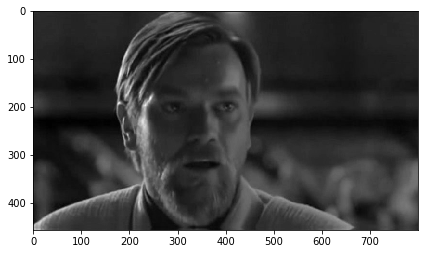

In [4]:
print('Shape before padding', obi.array.shape)
obi_padded, h, w= pad(obi.array)
imshow(obi_padded)
print('Shape after padding', obi_padded.shape)

We will now focus on one macroblock, after splitting the image

In [5]:
def split(arr, q, space, wpad, hpad):
    split_height = arr.shape[0] / 8
    split_width = arr.shape[1] / 8
    return (
        np.array(
            [
                [MacroBlock(y, q, space) for y in np.split(x, split_width, axis=1)]
                for x in np.split(arr, split_height)
            ]
        ),
        wpad,
        hpad,
    )

In [6]:
macroblocks = split(obi_padded, qfactor, 'RGB', w, h)

One of the macro blocks contains those greyscale values. We see that the are all very close to each other.

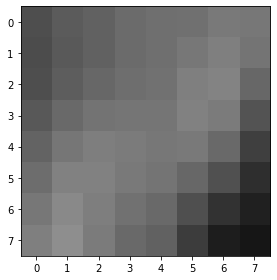

In [7]:
imshow(macroblocks[0][13, 25].array)

We will first apply the DCT on this block, then use the quantization matrix to retain the relevant values, with the help of the quality factor q.

In fact those operations are all done in the constructor of our macroblock class.

In [8]:
def dct8_line(n):
    return np.fromfunction(lambda i: np.cos((i * 2 * n + n) * np.pi / 16), (8,))

def build_dct8():
    return 0.5 * np.array(
        [
            np.full((8,), 1 / np.sqrt(2)),
            dct8_line(1),
            dct8_line(2),
            dct8_line(3),
            dct8_line(4),
            dct8_line(5),
            dct8_line(6),
            dct8_line(7),
        ]
    )
build_dct8()

array([[ 0.35355339,  0.35355339,  0.35355339,  0.35355339,  0.35355339,
         0.35355339,  0.35355339,  0.35355339],
       [ 0.49039264,  0.41573481,  0.27778512,  0.09754516, -0.09754516,
        -0.27778512, -0.41573481, -0.49039264],
       [ 0.46193977,  0.19134172, -0.19134172, -0.46193977, -0.46193977,
        -0.19134172,  0.19134172,  0.46193977],
       [ 0.41573481, -0.09754516, -0.49039264, -0.27778512,  0.27778512,
         0.49039264,  0.09754516, -0.41573481],
       [ 0.35355339, -0.35355339, -0.35355339,  0.35355339,  0.35355339,
        -0.35355339, -0.35355339,  0.35355339],
       [ 0.27778512, -0.49039264,  0.09754516,  0.41573481, -0.41573481,
        -0.09754516,  0.49039264, -0.27778512],
       [ 0.19134172, -0.46193977,  0.46193977, -0.19134172, -0.19134172,
         0.46193977, -0.46193977,  0.19134172],
       [ 0.09754516, -0.27778512,  0.41573481, -0.49039264,  0.49039264,
        -0.41573481,  0.27778512, -0.09754516]])

This code is used to build the dct8 matrix used to perform the dct following this formula :

$$D_N(j,k) = \alpha(j) \cos\left(\frac{\pi(2k + 1)j}{2N}\right) $$
where $\alpha(j)=$
$$
\begin{cases}
    \sqrt{\frac1N} \text{ if $j=0$} \\
    \sqrt{\frac2N} \text{ otherwise}
\end{cases}

 $$

The operation is then easily done.
$$\mathcal{I}_D = D_8\mathcal{I}D_8^\intercal $$

We also substract 128 from all values because the DC coefficient is often around this value, and this way it can sometimes be taken to 0.

array([[-2.00250000e+02,  6.00093859e+01, -7.77977056e+01,
         1.04824357e+01, -3.55000000e+01, -9.05834356e-01,
        -1.40474018e+01,  5.44618067e-01],
       [ 3.66490451e+01, -1.60737306e+02,  2.55403444e+01,
        -4.40711144e+00, -9.65111773e-01,  1.74756126e+01,
        -3.76967947e-01, -1.33478341e+00],
       [-4.00194650e+01,  3.47248799e+01,  2.00030483e+01,
        -1.47102567e+01,  2.44624103e+01, -1.72199973e+01,
        -3.53553391e-01,  4.46400050e-01],
       [ 1.16710770e+01,  4.49863973e+00, -7.71568885e+00,
        -1.24948304e+00, -5.61542271e-01, -9.19032884e-03,
        -5.64852231e-02,  4.54446556e-01],
       [ 8.54871729e-15,  7.24833997e+00, -2.30969883e-01,
        -2.17925523e-02,  2.50000000e-01, -1.28419856e-01,
         9.56708581e-02,  2.63820123e-01],
       [-4.49127884e-02,  1.74233100e-01, -1.01883806e-01,
         4.47916452e-01, -5.25546771e-01, -4.51004076e-01,
         7.52311642e-03, -2.11515381e-01],
       [ 7.01241267e-02, -6.536933

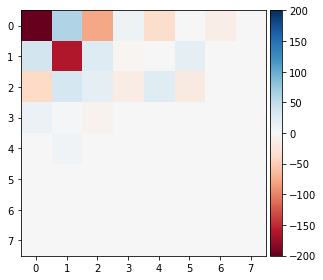

In [9]:
def spectrum(mb):
    return (
        MacroBlock.d8 @ (np.array(mb.array, dtype="int") - 128) @ MacroBlock.d8.T
    )
dct_obi_macro = spectrum(macroblocks[0][13, 25])
imshow(dct_obi_macro)
dct_obi_macro

After having applied the DCT we need to round the block values, so that we only keep the significant ones.

This is also where the quality factor will come into play through the quantization matrix.

Here instead of flooring the value returned by $ \frac{Q_{mat} \times \alpha + 50}{100}$, we round it because flooring was giving us error for quality factors that were too high or too low (< 5 or > 95).

array([[-13.,   5.,  -8.,   1.,  -1.,  -0.,  -0.,   0.],
       [  3., -13.,   2.,  -0.,  -0.,   0.,  -0.,  -0.],
       [ -3.,   2.,   1.,  -1.,   1.,  -0.,  -0.,   0.],
       [  1.,   0.,  -0.,  -0.,  -0.,  -0.,  -0.,   0.],
       [  0.,   0.,  -0.,  -0.,   0.,  -0.,   0.,   0.],
       [ -0.,   0.,  -0.,   0.,  -0.,  -0.,   0.,  -0.],
       [  0.,  -0.,  -0.,   0.,  -0.,   0.,  -0.,   0.],
       [ -0.,  -0.,  -0.,  -0.,  -0.,   0.,  -0.,  -0.]])

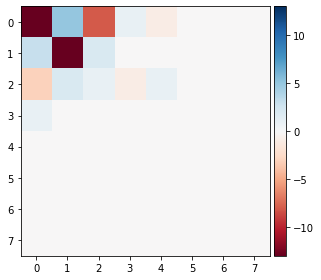

In [10]:
q_mat = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ]
)

def quantize(spectrum, q):
    alpha = 5000 / q if q < 50 else 200 - 2 * q
    qmat = MacroBlock.q_mat
    return np.round(spectrum / np.round((qmat * alpha + 50) / 100))

obi_macro_quant = quantize(dct_obi_macro, qfactor)

imshow(obi_macro_quant)
obi_macro_quant

We see that, compared to the state of the block after the DCT, we have lost some of the less importants coefficients.

Now we only have to remove the zero coefficients after the last non zero one, and put those coefficients in an array following a zig zag. It is done by the following code.

![](zigzag.png)


In [11]:
def zigzag(m):
    # Ugly zigzag line
    z = np.concatenate(
        [
            np.diagonal(m[::-1, :], i)[:: (1 - 2 * (i % 2))]
            for i in range(1 - m.shape[0], m.shape[0])
        ]
    )
    # Get a filter, make it so we only lose the last zeros from zigzag.
    if z[-1] == 0:
        f = z != 0
        if True in f:
            f[: len(f) - f[::-1].tolist().index(True) - 1] = True
        return z[f]
    else:
        return z
zigzag(obi_macro_quant)

array([-13.,   3.,   5.,  -8., -13.,  -3.,   1.,   2.,   2.,   1.,  -1.,
        -0.,   1.,   0.,   0.,  -0.,   0.,  -0.,  -1.,  -0.,  -0.,  -0.,
         0.,   1.])

In [12]:
macroblocks[0][13, 25].coefs

array([-13.,   3.,   5.,  -8., -13.,  -3.,   1.,   2.,   2.,   1.,  -1.,
        -0.,   1.,   0.,   0.,  -0.,   0.,  -0.,  -1.,  -0.,  -0.,  -0.,
         0.,   1.])

We find the same coefficients, that is reassuring. We can now display the compression ratio of this macro block.

In [13]:
1 / macroblocks[0][13, 25].ratio

2.6666666666666665

In [14]:
get_ratio_channel(macroblocks[0])

NameError: name 'get_ratio_channel' is not defined

## Greyscale decompression



Now that we can store the compressed version of our image, we would like to uncompress it to be able to see it.
The previous steps have to be done in reverse.
- For each macroblock, unzigzag the array back into a matrix
- For each macroblock, unquantize the matrix by multipliying by the quantizition matrix qmat (remember that is where information is lost)
- For each macroblock, applying the reverse DCT transform.
- Rebuilding the image from the macroblocks
All of these steps are done in our code by the method `greyscale_uncompress`

We have the `macroblocks` object which is a tuple containing an array of arrays of the macroblocks coefficients of the image as well as the padding information.

Let us focus back on the macroblock at position 13, 25. We first need to unzigzag the array back into a matrix.

In [15]:
macroblocks[0][13, 25].coefs

array([-13.,   3.,   5.,  -8., -13.,  -3.,   1.,   2.,   2.,   1.,  -1.,
        -0.,   1.,   0.,   0.,  -0.,   0.,  -0.,  -1.,  -0.,  -0.,  -0.,
         0.,   1.])

In [16]:
def unzigzag(z, s):
    z = np.pad(z, (0, 64 - len(z)), constant_values=0)
    res = np.zeros((s, s), dtype="int")
    i = 0
    for j in range(1 - s, 1):
        diag_size = s - abs(j)
        np.fill_diagonal(
            res[::-1, :][abs(j) :, :], z[i : i + diag_size][:: (1 - 2 * (j % 2))]
        )
        i += diag_size
    for j in range(1, s):
        diag_size = s - abs(j)
        np.fill_diagonal(
            res[::-1, :][:, j:], z[i : i + diag_size][:: (1 - 2 * (j % 2))]
        )
        i += diag_size
    return res
unzizaged1325 = unzigzag(macroblocks[0][13, 25].coefs, 8)
unzizaged1325

array([[-13,   5,  -8,   1,  -1,   0,   0,   0],
       [  3, -13,   2,   0,   0,   0,   0,   0],
       [ -3,   2,   1,  -1,   1,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]])

We then need to unquantize this matrix, multiplying by the matrix `qmat`.

In [17]:
def unquantize(m, q, space):
    alpha = 5000 / q if q < 50 else 200 - 2 * q
    qmat = MacroBlock.quv_mat if space == "YUV" else MacroBlock.q_mat
    return m * np.round((qmat * alpha + 50) / 100)

unquantized1325 = unquantize(unzizaged1325, qfactor, 'greyscale')
unquantized1325

array([[-208.,   60.,  -80.,   16.,  -24.,    0.,    0.,    0.],
       [  36., -156.,   28.,    0.,    0.,    0.,    0.,    0.],
       [ -42.,   28.,   16.,  -24.,   40.,    0.,    0.,    0.],
       [  14.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])

Now we have to apply the inverse of the DCT, to retrieve the pixels of our macroblock.

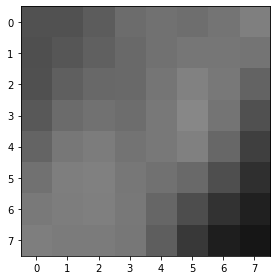

In [18]:
def unspectrum(spectrum):
    return np.array(
        np.clip(np.round(MacroBlock.d8.T @ spectrum @ MacroBlock.d8) + 128, 0, 255),
        dtype="uint8",
    )
mb_1325 = unspectrum(unquantized1325)
mb_1325
imshow(mb_1325)

We have to decompress each macroblock of the array this way, and merge them together to retrieve the original image

In [19]:
def reassemble_macroblocks(macroblocks, q, mode="RGB"):
        return MyImage(
            np.concatenate(
                np.concatenate(
                    np.array(
                        [
                            [mb2.uncompress(q, mode) for mb2 in mb1]
                            for mb1 in macroblocks
                        ]
                    ),
                    axis=1,
                ),
                axis=1,
            ),
            space="Grayscale",
        )

In [20]:
obi_decompressed_greyscale = reassemble_macroblocks(macroblocks[0], qfactor)

(456, 800)

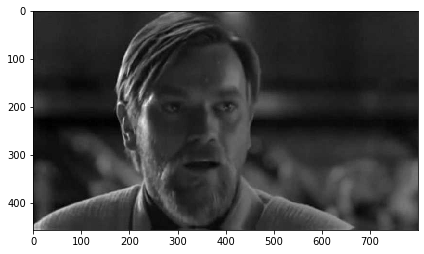

In [21]:
imshow(obi_decompressed_greyscale.array)
obi_decompressed_greyscale.shape

The final step is to trim back the image to its original dimensions, which means removing the padding added in the first step.

(450, 800)

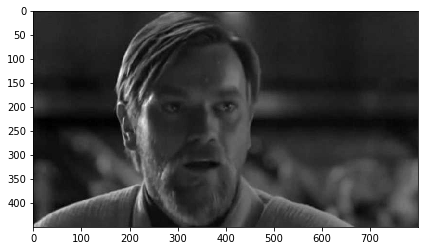

In [22]:
obi_true_decomp_grey = MyImage.trim(obi_decompressed_greyscale, macroblocks[1], macroblocks[2])
imshow(obi_true_decomp_grey.array)
obi_true_decomp_grey.shape

## The problem of color
Now that greyscale compression is out of the way, we will explain the different ways in which an image with color channels can be compressed

## The RGB way
This way is the simplest. The idea is to do the compression on the three channels R, G, and B as if it were a grayscale image.

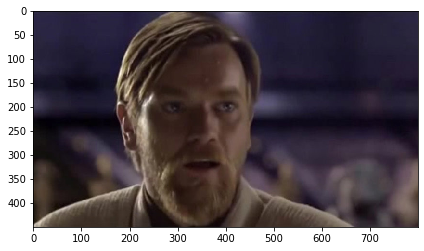

In [23]:
obi_col = MyImage.from_image("hello_there.jpg")
imshow(obi_col.array)

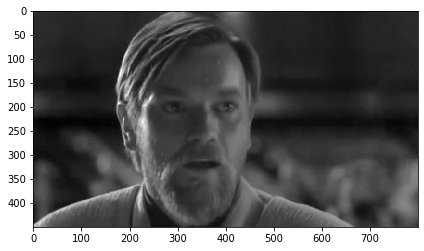

In [24]:
r = obi_col.channel0()
g = obi_col.channel1()
b = obi_col.channel2()
imshow(r.array)

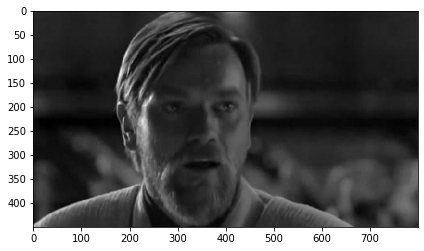

In [25]:
imshow(g.array)

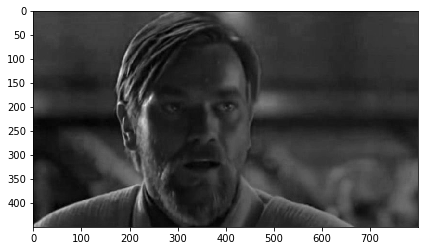

In [26]:
imshow(b.array)

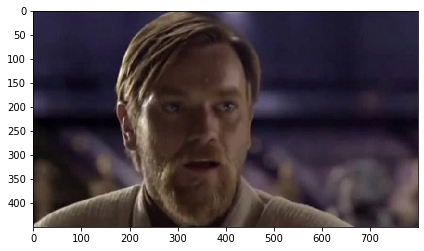

In [27]:
obi_rgb_compressed_mb = [r.get_macro_arrays(qfactor), g.get_macro_arrays(qfactor), b.get_macro_arrays(qfactor)]


imshow(MyImage.rgb_uncompress(obi_rgb_compressed_mb, qfactor).array)

In [94]:
def get_ratio_channel(macroblocks, size=0):
    nbcoefs = 0
    count = 0
    for mb in macroblocks:
        for submb in mb:
            nbcoefs += len(submb.coefs)
            count += 1
    if nbcoefs == 0:
        return 0
    if size != 0:
        return (64 * size)/ nbcoefs
    return (64 * count) / nbcoefs

def output_ratios_channels(macroblocks_c):
    nb_macroblocks = macroblocks_c[0][0].shape[0] * macroblocks_c[0][0].shape[1]
    channel_0 = get_ratio_channel(macroblocks_c[0][0])
    channel_1 = get_ratio_channel(macroblocks_c[1][0], nb_macroblocks)
    channel_2 = get_ratio_channel(macroblocks_c[2][0], nb_macroblocks)
    return (channel_0 + channel_1 + channel_2) / 3

In [29]:
output_ratios_channels(obi_rgb_compressed_mb)

Channel 0 has ratio : 13.503609106052194
Channel 1 has ratio : 13.621088790979016
Channel 2 has ratio : 13.25629565027799


## The YUV way

RGB works, but is not that efficient, since the some of the same information basically has to be saved multiple times. 

The YUV color space allows us to have the data about the luminance of the image, and its color, in three separate channels.

To change the space to YUV from RGB, we are using the `skimage` library. Since the values in the numpy array that its functions returns are between 0 and 1 for Y, -0.436 and 0.436 for U and -0.615 and 0.615 for V, we scale those values back between 0 and 255.

Here is the YUV image as seen as a RGB image.

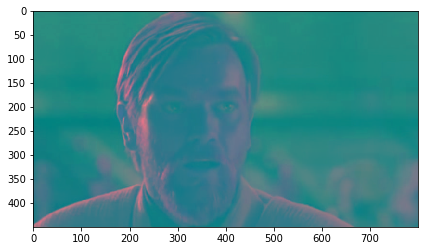

In [30]:
def RGB_to_YUV(img):
    if img.space != "RGB":
        raise Exception(f"Image space should be RGB instead of {img.space}")
    yuv = color.rgb2yuv(img.array)
    yuv[:, :, 0] *= 255
    yuv[:, :, 1] += 0.436
    yuv[:, :, 1] *= 255 / 0.872
    yuv[:, :, 2] += 0.615
    yuv[:, :, 2] *= 255 / 1.23
    return MyImage(np.clip(np.round(yuv), 0, 255), space="YUV")
obi_yuv = MyImage.RGB_to_YUV(obi_col)
imshow(obi_yuv.array)

Obviously we also have a method to go from YUV to RGB, again using `skimage`.

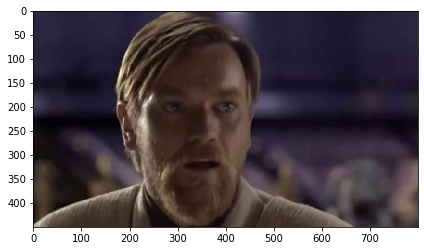

In [31]:
def YUV_to_RGB(img):
    if img.space != "YUV":
        raise Exception(f"Image space should be YUV instead of {img.space}")
    arr = np.array(img.array, dtype="float64")
    arr[:, :, 0] /= 255
    arr[:, :, 1] /= 255 / 0.872
    arr[:, :, 1] -= 0.436
    arr[:, :, 2] /= 255 / 1.23
    arr[:, :, 2] -= 0.615
    return MyImage(np.clip(np.round(color.yuv2rgb(arr) * 255), 0, 255))
imshow(MyImage.YUV_to_RGB(obi_yuv).array)

We can then show the differents channels of the image as seen as greyscale images

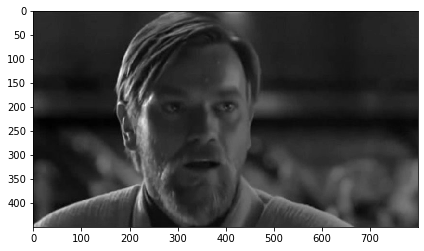

In [32]:
imshow(obi_yuv.channel0().array)

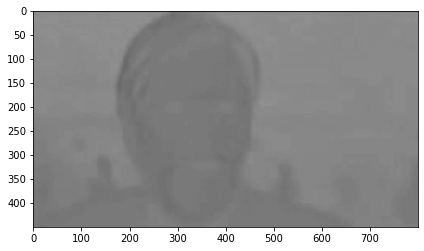

In [33]:
imshow(obi_yuv.channel1().array)

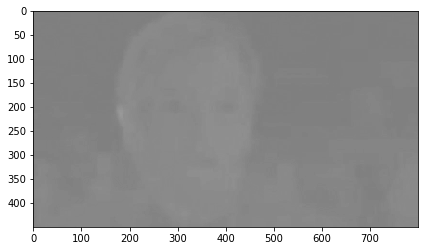

In [34]:
imshow(obi_yuv.channel2().array)

Clearly, in this color space, the information about the variation in intensity of the image is decorelated from the information about its color. The U and V channels are mostly solid color, which is very good for our compression algorithm.

They also appear to be less important than the Y channel. We will thus be able to shrink their quality without affecting the compression quality too much.

The steps are similar to the greyscale compression. Only, now, there is one special quantization matrix `quv_mat` for the U and V channels.

In [35]:
quv_mat = np.array(
    [
        [17, 18, 24, 47, 99, 99, 99, 99],
        [18, 21, 26, 66, 99, 99, 99, 99],
        [24, 26, 56, 99, 99, 99, 99, 99],
        [47, 66, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
    ]
)

In [36]:
obi_yuv_mb = MyImage.yuv_compress(obi_col, qfactor)

In [37]:
output_ratios_channels(obi_yuv_mb)

Channel 0 has ratio : 21.56665681347916
Channel 1 has ratio : 53.837072018890204
Channel 2 has ratio : 86.7126218207749


In [38]:
obi_yuv_uncompress = MyImage.yuv_uncompress(obi_yuv_mb, qfactor)

(450, 800, 3)

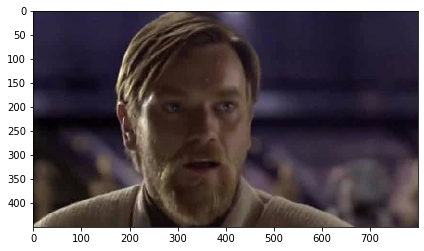

In [39]:
imshow(obi_yuv_uncompress.array)
obi_yuv_uncompress.array.shape

## Reducing the quality of U and V

We can further improve compression quality by downsampling U and V so that we only keep half or one quarter of the original information. 

This method is known as the 4:2:2 and 4:2:0 downsampling schemes.

- 4:4:4 Downsampling scheme : The three channels are kept at their original quality
- 4:2:2 Downsampling scheme : One of two columns are thrown away for the U and V channels
- 4:2:0 Downsampling scheme : One of two columns and one of two lines are thrown away for the U and V channels

The `MyImage.downsampling` method is used to downsample the U and V channels. The argument is the division factor.

In [40]:
def downsampling(self, sizex, sizey):
    arr = self.array[::sizey, ::sizex]
    return MyImage(arr, space=self.space)

Here for example we are keeping one in 10 columns and lines

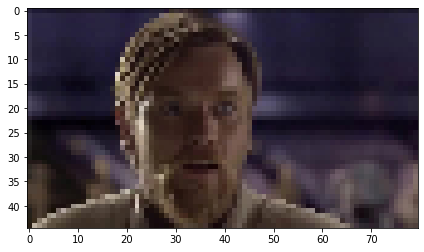

In [41]:
obi_col_downsamp = obi_col.downsampling(10,10)
imshow(obi_col_downsamp.array)

Then we can upsample the downsampled image to retrieve an image of the right size. This is done using the `MyImage.upsampling` method and achieves this through nearest neighbor interpolation. 

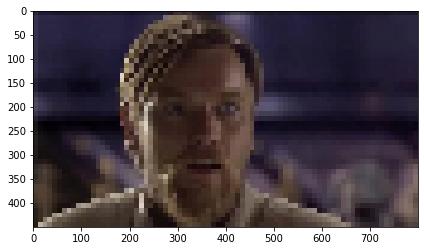

In [42]:
imshow(obi_col_downsamp.upsampling(10, 10).array)

We can try compressing the same image using different downsampling schemes, and comparing the different channels compression ratios.

In [43]:
obi_yuv_422 = MyImage.yuv_compress(obi_col, qfactor, '4:2:2')
obi_yuv_420 = MyImage.yuv_compress(obi_col, qfactor, '4:2:0')

In [80]:
print(output_ratios_channels(obi_yuv_422))

91.3288930102999


In [81]:
print(output_ratios_channels(obi_yuv_420))

168.14927852808526


In [67]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [95]:
rmse_gray_array = []
rmse_rgb_array = []
rmse_444_array = []
rmse_422_array = []
rmse_420_array = []

for qfactor in [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
    #do all the different types of compression for the given qfactor
    obi_gray = MyImage.grayscale_compress(obi_col.grayscale(), qfactor)
    obi_rgb = MyImage.rgb_compress(obi_col, qfactor)
    obi_yuv_444 = MyImage.yuv_compress(obi_col, qfactor)
    obi_yuv_422 = MyImage.yuv_compress(obi_col, qfactor, '4:2:2')
    obi_yuv_420 = MyImage.yuv_compress(obi_col, qfactor, '4:2:0')
    
    #uncompress all the different types for the given qfactor
    obi_gray_uncompress = MyImage.grayscale_uncompress(obi_gray, qfactor)
    obi_rgb_uncompress = MyImage.rgb_uncompress(obi_rgb, qfactor)
    obi_yuv_444_uncompress = MyImage.yuv_uncompress(obi_yuv_444, qfactor)
    obi_yuv_422_uncompress = MyImage.yuv_uncompress(obi_yuv_422, qfactor, '4:2:2')
    obi_yuv_420_uncompress = MyImage.yuv_uncompress(obi_yuv_420, qfactor, '4:2:0')
    
    #compute the rmse for each uncompressed image
    rmse_gray_array.append(rmse(obi_col.grayscale().array, obi_gray_uncompress.array))
    rmse_rgb_array.append(rmse(obi_col.array, obi_rgb_uncompress.array))
    rmse_444_array.append(rmse(obi_col.array, obi_yuv_444_uncompress.array))
    rmse_422_array.append(rmse(obi_col.array, obi_yuv_422_uncompress.array))
    rmse_420_array.append(rmse(obi_col.array, obi_yuv_420_uncompress.array))

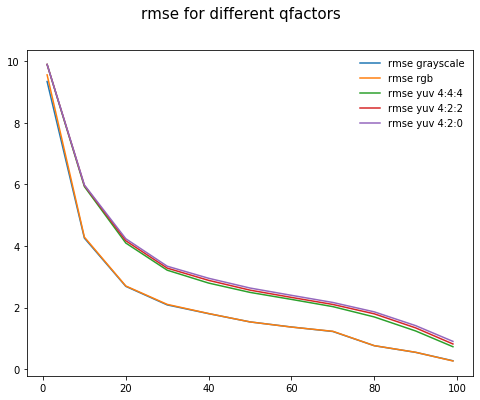

In [99]:
x = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]

# Initialize the figure and axes
fig, ax = plt.subplots(1, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('rmse for different qfactors ', fontsize=15)

# Draw all the lines in the same plot, assigning a label for each one to be
# shown in the legend
ax.plot(x, rmse_gray_array, label="rmse grayscale")
ax.plot(x, rmse_rgb_array, label="rmse rgb")
ax.plot(x, rmse_444_array, label="rmse yuv 4:4:4")
ax.plot(x, rmse_422_array, label="rmse yuv 4:2:2")
ax.plot(x, rmse_420_array, label="rmse yuv 4:2:0")

# Add a legend with title, position it on the lower right (loc) with no box framing (frameon)
ax.legend(loc="upper right", frameon=False)

# Show the plot
plt.show()

## Using the `MyImage` class

We provide a class fitted with methods to open, compress and decompress an image.

- `MyImage.from_image(path)` : opens an image as a RGB image at the given path using the pillow library
- `MyImage.to_image()` : outputs the image as a pillow image
- `MyImage.grayscale()` : converts the image to grayscale
- `MyImage.RGB_to_YUV(img)` : return a copy of the given image, converted to the YUV color space
- `MyImage.YUV_to_RGB(img)` : return a copy of the given image, converted to the RGB color space from YUV
- `MyImage.grayscale_compress(img, q)` : compress a grayscale image, using the quality factor q
- `MyImage.rgb_compress(img, q)` : compress a RGB image, compressing all R, G and B channels separately
- `MyImage.rgb_uncompress(macro_arr, q)` : uncompress a RGB compressed image from its macroarray and quality factor
- `MyImage.yuv_compress(img, q, downsampling)` : compress a RGB image, converting to YUV color space and applying the correct downsampling scheme
- `MyImage.yuv_uncompress(macro_arr, q, downsampling)`: uncompress a YUV compressed image back to RGB
- `MyImage.trim(width, height)` : trims the image from the bottom right corner. We use this method to remove the padding
- `MyImage.upsampling(x, y)` : creates a larger image, multiplying the size by the factors x and y, using nearest-neighbor interpolation
- `MyImage.downsampling(x, y)` : create a smaller image, dividing the size by the factors x and y, keeping 1 out of x columns and 1 out of y lines.

